In [1]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [4]:
data_bbox = np.load('/content/drive/MyDrive/helen_finale/data_bbox.npy')
data_names = np.load('/content/drive/MyDrive/helen_finale/data_names.npy')
data_attenction = np.load('/content/drive/MyDrive/helen_finale/data_attenction.npy')
print(data_names[1])

103887554_1.jpg


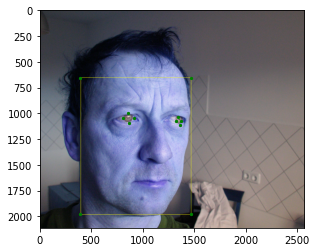

In [5]:
im=cv2.imread(('/content/drive/MyDrive/helen_finale/train_1/'+data_names[1]))
plt.imshow(im)
plt.scatter(data_bbox[1][:,0], data_bbox[1][:,1], s = 5, c = 'g') 
plt.imshow(cv2.rectangle(im, (data_bbox[1][8,0], data_bbox[1][8,1]), (data_bbox[1][9,0], data_bbox[1][9,1]), (255, 255, 0), 2))

In [6]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks,crops):
        left = int(crops[0])
        top =  int(crops[1])
        width = int(crops[2])
        height = int(crops[3])


        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [7]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, df_names, df_bbox, transform=None):

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        
        for filename in df_names:
            self.image_filenames.append("/content/drive/MyDrive/helen_finale/train_1/"+filename)
            

        for num in df_bbox:
             landmark = []
             crop=[]
             for i in range(8):
                x_coordinate = int(num[i][0])
                y_coordinate = int(num[i][1])
                landmark.append([x_coordinate, y_coordinate])
             self.landmarks.append(landmark)


             crop.append(int(num[8][0]))
             crop.append(int(num[8][1]))
             crop.append((int(num[9][0])-int(num[8][0])))
             crop.append((int(num[9][1])-int(num[8][1])))

             self.crops.append(crop)
            
        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(data_names,data_bbox,Transforms())

tensor([[203.8393,  68.1478],
        [195.9077,  62.1492],
        [192.3418,  68.5105],
        [200.2894,  75.0152],
        [106.6768,  65.9777],
        [ 94.5217,  58.7613],
        [ 84.3355,  67.5270],
        [ 96.6997,  74.7367]])


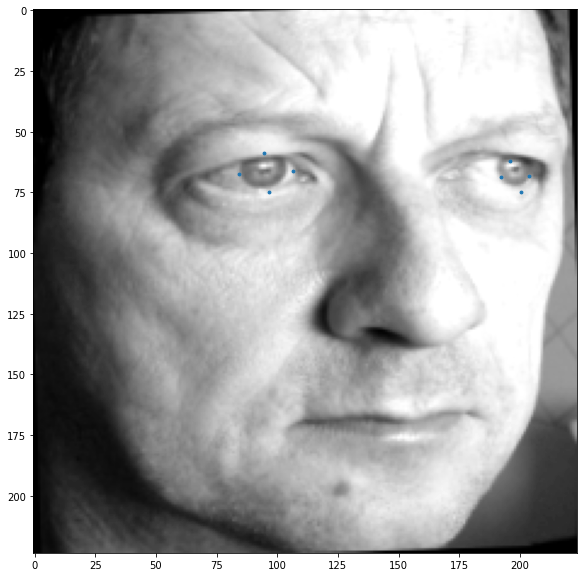

In [8]:
image, landmarks = dataset[1]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);     
print(landmarks)   

In [9]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_test_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set -len_test_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset, test_dataset= torch.utils.data.random_split(dataset , [len_train_set, len_valid_set, len_test_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2) #64->16
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2) #64->16
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=2) 

The length of Train set is 2086
The length of Valid set is 231


In [10]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([16, 1, 224, 224])
torch.Size([16, 8, 2])


In [11]:
class Network(nn.Module):
    def __init__(self,num_classes=16): #num_classe 16->1
        super().__init__()
        self.model_name='resnet152'
        self.model=models.resnet152()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) 
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [12]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [13]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()    

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
#search pytorch adam and costumise

loss_min = np.inf
num_epochs = 40

start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Valid Steps: 29/29  Loss: 0.0081 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0842  Valid Loss: 0.0081
--------------------------------------------------

Minimum Validation Loss of 0.0081 at epoch 1/40
Model Saved

Valid Steps: 29/29  Loss: 0.0068 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0067  Valid Loss: 0.0068
--------------------------------------------------

Minimum Validation Loss of 0.0068 at epoch 2/40
Model Saved

Valid Steps: 29/29  Loss: 0.0074 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0063  Valid Loss: 0.0074
--------------------------------------------------
Valid Steps: 29/29  Loss: 0.0052 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0063  Valid Loss: 0.0052
--------------------------------------------------

Minimum Validation Loss of 0.0052 at epoch 4/40
Model Saved

Valid Steps: 29/29  Loss: 0.0052 
----------------------------------------

Total number of test images: 231
Elapsed Time : 2.2659618854522705


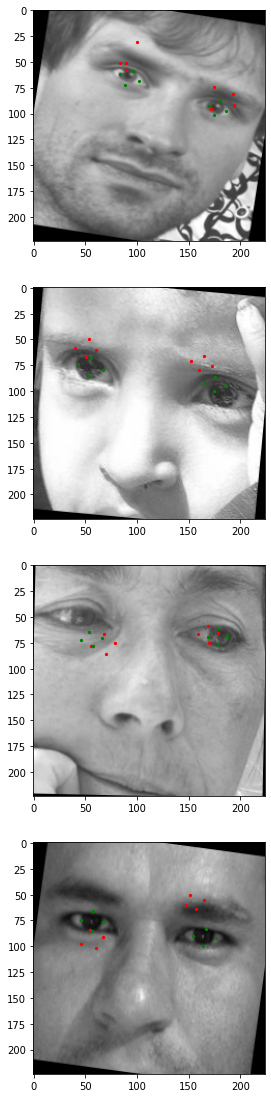

In [14]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/face_landmarks.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(test_loader))
    
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,16,2) #secondo 16->1
    
    plt.figure(figsize=(10,40))
    
    for img_num in range(4):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:8,0], predictions[img_num,:8,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 